In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

from scipy import stats, optimize
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.pipeline import Pipeline

from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import explained_variance_score, r2_score, median_absolute_error, mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The pandas version is {}.'.format(pd.__version__))
print('The numpy version is {}.'.format(np.__version__))

The scikit-learn version is 0.18.1.
The pandas version is 0.19.2.
The numpy version is 1.12.0.


In [2]:
goal_features = ['murders', 'murdPerPop', 'rapes', 'rapesPerPop', 'robberies','robbbPerPop',
                 'assaults', 'assaultPerPop', 'burglaries', 'burglPerPop', 'larcenies', 'larcPerPop',
                 'autoTheft', 'autoTheftPerPop', 'arsons', 'arsonsPerPop', 'violentPerPop', 'nonViolPerPop']

non_predictive_features = ['communityname', 'state', 'countyCode', 'communityCode', 'fold']

In [3]:
df = pd.read_csv('../datasets/UnnormalizedCrimeData.csv');
df = df.replace('?',np.NAN)
features = [x for x in df.columns if x not in goal_features and x not in non_predictive_features]
len(features)

124

In [4]:
def drop_rows_with_null_goal_feature(old_df, feature):
    new_df = old_df.dropna(subset=[feature])
    return new_df

In [38]:
class GradientBoostRegression:
    
    def __init__(self, df, goal_feature, loss_function):
        self.goal_df = drop_rows_with_null_goal_feature(df, goal_feature)
        self.goal_df[[goal_feature]] = self.goal_df[[goal_feature]].apply(pd.to_numeric)
        self.goal_df = self.goal_df[self.goal_df[goal_feature] <= self.goal_df[goal_feature].quantile(0.98)]
        imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
        imr = imr.fit(self.goal_df[features])
        imputed_data = imr.transform(self.goal_df[features]);
        self.df_X_train, self.df_X_test, self.df_y_train, self.df_y_test = \
        train_test_split(imputed_data, self.goal_df[goal_feature], test_size=0.10)
        self.estimator = GradientBoostingRegressor(loss=loss_function)
    
    def train(self):
        self.estimator.fit(self.df_X_train, self.df_y_train)
        
        mse = mean_squared_error(self.df_y_test, self.estimator.predict(self.df_X_test))
        print("MSE: %.4f" % mse)

    def plot_deviance(self):
        test_score = np.zeros((100,), dtype=np.float64)
        for i, y_pred in enumerate(self.estimator.staged_predict(self.df_X_test)):
            test_score[i] = self.estimator.loss_(self.df_y_test, y_pred)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title('Deviance')
        plt.plot(np.arange(100) + 1, self.estimator.train_score_, 'b-',
                 label='Training Set Deviance')
        plt.plot(np.arange(100) + 1, test_score, 'r-',
                 label='Test Set Deviance')
        plt.legend(loc='upper right')
        plt.xlabel('Boosting Iterations')
        plt.ylabel('Deviance')
        plt.show()
    
    def plot_feature_importance(self):
        plt.figure(figsize=(12, 6))
        feature_importance = self.estimator.feature_importances_
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_index = np.argsort(feature_importance)[::-1][:10]
        pos = np.arange(sorted_index.shape[0]) + .5
        plt.subplot(1, 2, 2)
        plt.barh(pos, feature_importance[sorted_index], align='center')
        plt.yticks(pos, self.goal_df.columns[sorted_index])
        plt.xlabel('Relative Importance')
        plt.title('Top 10 Features')
        plt.show()

MSE: 7.9642


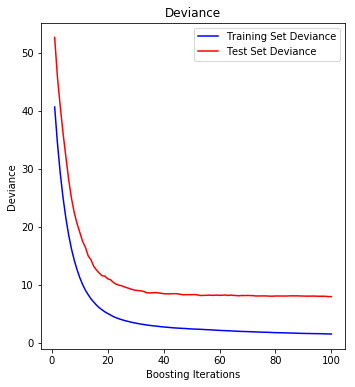

In [39]:
murdersRegressor = GradientBoostRegression(df, 'murders', 'ls')
murdersRegressor.train()
murdersRegressor.plot_deviance()

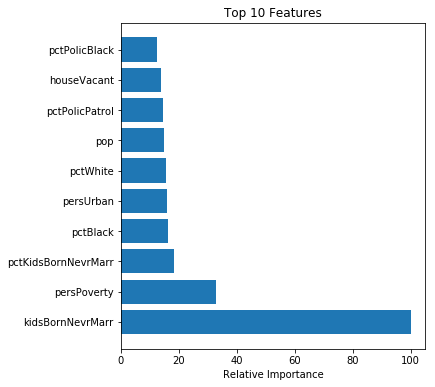

In [40]:
murdersRegressor.plot_feature_importance()

MSE: 191.1274


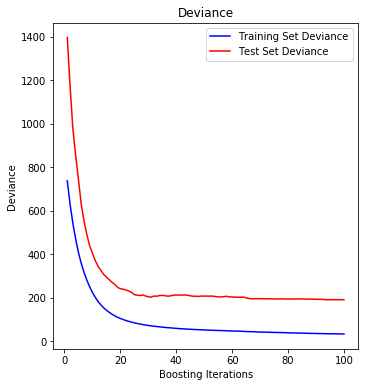

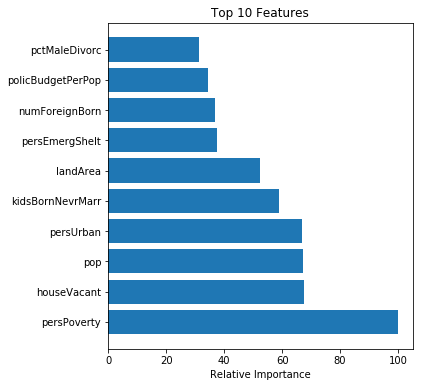

In [41]:
rapesRegressor = GradientBoostRegression(df, 'rapes', 'ls')
rapesRegressor.train()
rapesRegressor.plot_deviance()
rapesRegressor.plot_feature_importance()

MSE: 4183.9268


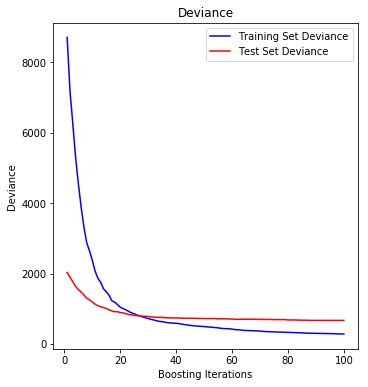

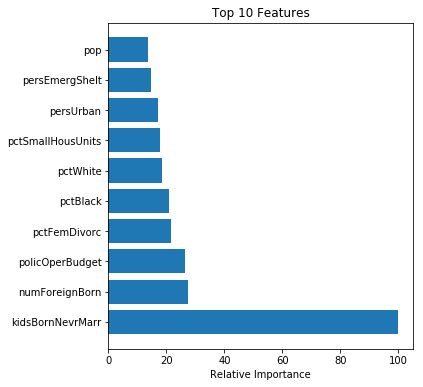

In [42]:
robberiesRegressor = GradientBoostRegression(df, 'robberies', 'huber')
robberiesRegressor.train()
robberiesRegressor.plot_deviance()
robberiesRegressor.plot_feature_importance()

MSE: 32965.4512


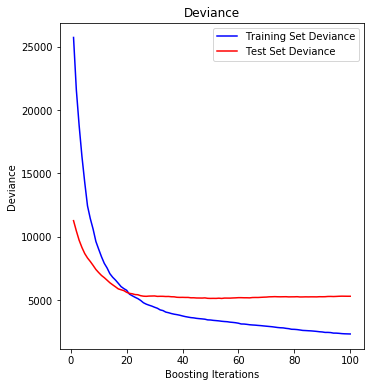

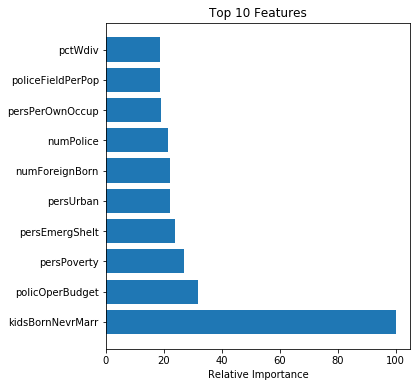

In [43]:
assaultsRegressor = GradientBoostRegression(df, 'assaults', 'huber')
assaultsRegressor.train()
assaultsRegressor.plot_deviance()
assaultsRegressor.plot_feature_importance()